In [40]:
%matplotlib inline

import time
import calendar
import codecs
import datetime
import json
import sys
import gzip
import string
import glob
import requests
import os

import numpy as np

# Twitter Crisis Anlytics

The following notebook walks us through a number of capabilities or common pieces of functionality one may want when analyzing Twitter following a crisis.
We will start by defining information for a set of events for which we have data.

In [41]:
crisisInfo = {
    "boston": {
        "name": "Boston Marathon Bombing",
        "time": 1368643740, # Timestamp in seconds since 1/1/1970, UTC
                            # 15 April 2013, 14:49 EDT -> 18:49 UTC
        "directory": "boston",
        "keywords": ["boston", "exploision", "bomb", "marathon"],
        "box": { # Bounding box for geographic limits
            "lowerLeftLon": -124.848974,
            "lowerLeftLat": 24.396308,
            "upperRightLon": -66.885444,
            "upperRightLat": 49.384358,
        }
    },
    
    "paris_hebdo": {
        "name": "Charlie Hebdo Attack",
        "time": 1420626600, # Timestamp in seconds since 1/1/1970, UTC
                            # 7 January 2015, 11:30 CET -> 10:30 UTC
        "directory": "paris_hebdo",
        "keywords": ["paris", "hebdo"],
        "box": {
            "lowerLeftLon": -5.1406,
            "lowerLeftLat": 41.33374,
            "upperRightLon": 9.55932,
            "upperRightLat": 51.089062,
        }
    },
    
    "paris_nov": {
        "name": "Paris November Attacks",
        "time": 1447446000, # Timestamp in seconds since 1/1/1970, UTC
                            # 13 November 2015, 20:20 UTC to 23:58 UTC
        "directory": "paris_nov",
        "keywords": ["paris", "shots", "explosion"],
        "box": {
            "lowerLeftLon": -5.1406,
            "lowerLeftLat": 41.33374,
            "upperRightLon": 9.55932,
            "upperRightLat": 51.089062,
        }
    },
    
    "brussels": {
        "name": "Brussels Transit Attacks",
        "time": 1458629880, # Timestamp in seconds since 1/1/1970, UTC
                            # 22 March 2016, 6:58 UTC to 08:11 UTC
        "directory": "brussels",
        "keywords": ["brussels", "bomb", "belgium", "explosion"],
        "box": {
            "lowerLeftLon": 2.54563,
            "lowerLeftLat": 49.496899,
            "upperRightLon": 6.40791,
            "upperRightLat": 51.5050810,
        }
    }
}

## Choose Your Crisis

Since we have several disasters we can look at and don't have time to explore them all, you can pick one and follow along with our analysis on the crisis that interests you.

To select the crisis you want, pick from the list printed below.

In [42]:
print "Available Crisis Names:"
for k in sorted(crisisInfo.keys()):
    print "\t", k

Available Crisis Names:
	boston
	brussels
	paris_hebdo
	paris_nov


In [43]:
# Replace the name below with your selected crisis
selectedCrisis = "paris_nov"

<hr>

## Topic 3.1: Reading Tweets

The first thing we do is read in tweets from a directory of compressed files. Our collection of compressed tweets is in the 00_data directory, so we'll use pattern matching (called "globbing") to find all the tweet files in the given directory.

Then, for each file, we'll open it, read each line (which is a tweet in JSON form), and build an object out of it. As part of this process, we will extract each tweet's post time and create a map from minute timestamps to the tweets posted during that minute.

In [44]:
# Determine host-specific location of data
tweetDirectory = crisisInfo[selectedCrisis]["directory"]
tweetGlobPath = os.path.join("..", "00_data", tweetDirectory, "statuses.log.*.gz")

print "Reading files from:", tweetGlobPath

# Dictionary for mapping dates to data
frequencyMap = {}

# For counting tweets
globalTweetCounter = 0

# Twitter's time format, for parsing the created_at date
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"

reader = codecs.getreader("utf-8")

for tweetFilePath in glob.glob(tweetGlobPath):
    print "Reading File:", tweetFilePath

    for line in gzip.open(tweetFilePath, 'rb'):

        # Try to read tweet JSON into object
        tweetObj = None
        try:
            tweetObj = json.loads(reader.decode(line)[0])
        except Exception as e:
            continue

        # Deleted status messages and protected status must be skipped
        if ( "delete" in tweetObj.keys() or "status_withheld" in tweetObj.keys() ):
            continue

        # Try to extract the time of the tweet
        try:
            currentTime = datetime.datetime.strptime(tweetObj['created_at'], timeFormat)
        except:
            print (line)
            raise

        currentTime = currentTime.replace(second=0)

        # Increment tweet count
        globalTweetCounter += 1

        # If our frequency map already has this time, use it, otherwise add
        if ( currentTime in frequencyMap.keys() ):
            timeMap = frequencyMap[currentTime]
            timeMap["count"] += 1
            timeMap["list"].append(tweetObj)
        else:
            frequencyMap[currentTime] = {"count":1, "list":[tweetObj]}

# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

# We want to look at per-minute data, so we fill in any missing minutes
timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
while ( thisTime <= lastTime ):
    if ( thisTime not in frequencyMap.keys() ):
        frequencyMap[thisTime] = {"count":0, "list":[]}
        
    thisTime = thisTime + timeIntervalStep

print "Processed Tweet Count:", globalTweetCounter

Reading files from: ../00_data/paris_nov/statuses.log.*.gz
Reading File: ../00_data/paris_nov/statuses.log.2015-11-13-22-sampled.gz
Reading File: ../00_data/paris_nov/statuses.log.2015-11-14-00-sampled.gz
Reading File: ../00_data/paris_nov/statuses.log.2015-11-13-20-sampled.gz
Reading File: ../00_data/paris_nov/statuses.log.2015-11-13-21-sampled.gz
Reading File: ../00_data/paris_nov/statuses.log.2015-11-13-23-sampled.gz
Reading File: ../00_data/paris_nov/statuses.log.2015-11-13-19-sampled.gz
Processed Tweet Count: 277141


<hr>
# Topic 4: Simple Frequency Analysis

In this section, we will cover a few simple analysis techniques to garner some small insights rapidly.

- Frequency Graph
- Top users
- Top hash tags
- Top URLs
- Top images
- Most retweeted tweet
- Keyword Frequency

### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per minute.

Crisis Time: 2015-11-13 20:20:00
Time Frame: 2015-11-13 19:00:00 2015-11-14 00:59:00


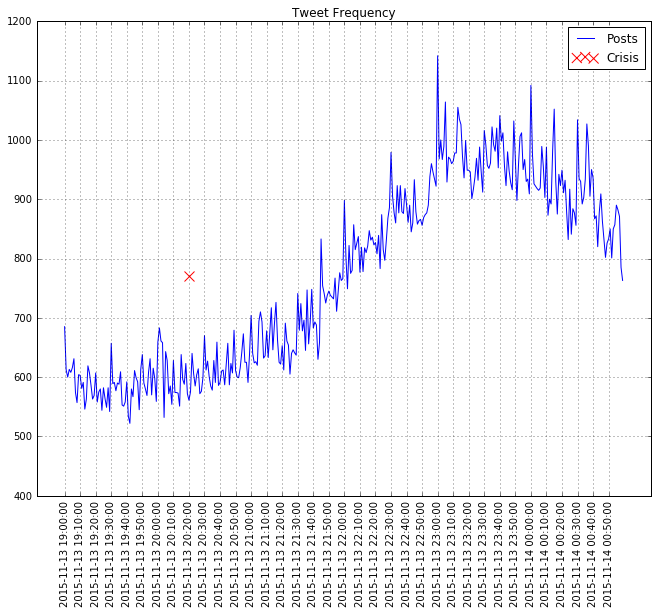

In [45]:
import matplotlib.pyplot as plt

crisisMoment = crisisInfo[selectedCrisis]["time"]
crisisTime = datetime.datetime.utcfromtimestamp(crisisMoment)
crisisTime = crisisTime.replace(second=0)
print "Crisis Time:", crisisTime

fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print "Time Frame:", sortedTimes[0], sortedTimes[-1]

# Get a count of tweets per minute
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]

# We'll have ticks every few minutes (more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 10)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
yData = [x if x > 0 else 0 for x in postFreqList]
ax.plot(range(len(frequencyMap)), yData, color="blue", label="Posts")

crisisXCoord = sortedTimes.index(crisisTime)
ax.scatter([crisisXCoord], [np.mean(yData)], c="r", marker="x", s=100, label="Crisis")

ax.grid(b=True, which=u'major')
ax.legend()

plt.show()

### Top Twitter Users

Finding good sources of information is really important during crises. 
On Twitter, the loudest or most prolific users are not necessarily good sources though.
We first check who these prolific users are by determining who was tweeting the most during this particular time span.

In [46]:
# Create maps for holding counts and tweets for each user
globalUserCounter = {}
globalUserMap = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if ( user not in globalUserCounter ):
            globalUserCounter[user] = 1
            globalUserMap[user] = [tweet]
        else:
            globalUserCounter[user] += 1
            globalUserMap[user].append(tweet)

print "Unique Users:", len(globalUserCounter.keys())

Unique Users: 258263


In [47]:
sortedUsers = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)
print "Top Ten Most Prolific Users:"
for u in sortedUsers[:10]:
    print u, globalUserCounter[u], "\n\t", "Random Tweet:", globalUserMap[u][0]["text"], "\n----------"

Top Ten Most Prolific Users:
SonyMusic 54 
	Random Tweet: @saddensoulshes Quanto carinho :) Aproveite o álbum https://t.co/ix4OnRpJoT &lt;3 Liam Niall Harry &amp; Louis #Fr1Day13BR https://t.co/i3hlzCUROV 
----------
tacobell 23 
	Random Tweet: @jazz_man77 #TacoEmojiEngine  https://t.co/VqdgABOPc3 
----------
multishow 18 
	Random Tweet: @Feoliveira_1 Tem vídeo liberado no Vlog da Jéssica! Quer ser a cara da riqueza? Assista: https://t.co/GvO89HKJsJ https://t.co/qKgwLFMVRr 
----------
roboko_001 17 
	Random Tweet: Saints should always be judged guilty until they are proven innocent.- George Orwell 
----------
YUDOK0RO 10 
	Random Tweet: ＠null https://t.co/56jOqiO2lo November 14, 2015 at 06:05AM #えどがわイケメン 
----------
tortuegenialee_ 8 
	Random Tweet: @ValenChevres Ouais mais on est pas terrible en attaque aussi xd 
----------
woulouis 8 
	Random Tweet: @SonyMusic eu tenho tanto orgulho deles meu deus eles mudaram tanto a minha vida e me fizeram querer ser melhor #FR1DAY13BR 337 
-------

Many of these tweets are not relevant to the event at hand.
Twitter is a very noisy place.

Hashtags, however, are high signal keywords. 
Maybe the most common hashtags will be more informative.

In [48]:
# A map for hashtag counts
hashtagCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
            else:
                hashtagCounter[hashtagString] += 1

print "Unique Hashtags:", len(hashtagCounter.keys())
sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
print "Top Twenty Hashtags:"
for ht in sortedHashtags[:20]:
    print "\t", "#" + ht, hashtagCounter[ht]

Unique Hashtags: 30855
Top Twenty Hashtags:
	#prayforparis 5917
	#paris 4692
	#fusillade 2662
	#porteouverte 1987
	#madeintheam 1867
	#aldubhappybdaylola 1832
	#fr1day13br 1521
	#purpose 1372
	#parisattacks 1078
	#showtimeharana 986
	#prayforjapan 897
	#bataclan 740
	#pushawardskathniels 696
	#parigi 440
	#1d 433
	#staracarabia 416
	#parís 387
	#prayforlebanon 380
	#rt 327
	#باريس 306


We can do the same with URLs to find the most shared URL.

In [49]:
# A map for hashtag counts
urlCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        urlList = tweet["entities"]["urls"]
        
        for url in urlList:
            urlStr = url["url"]
            
            if ( urlStr not in urlCounter ):
                urlCounter[urlStr] = 1
            else:
                urlCounter[urlStr] += 1

print "Unique URLs:", len(urlCounter.keys())
sortedUrls = sorted(urlCounter, key=urlCounter.get, reverse=True)
print "Top Twenty URLs:"
for url in sortedUrls[:20]:
    print "\t", url, urlCounter[url]

Unique URLs: 60962
Top Twenty URLs:
	https://t.co/ZWMJvhasht 153
	https://t.co/qYEj3RwRVN 57
	https://t.co/ix4OnRpJoT 57
	https://t.co/kkZVtzLLpU 53
	https://t.co/NY1u4iadas 51
	https://t.co/arRzih70fk 50
	https://t.co/jSVABzuodh 48
	https://t.co/R0lkxti8Mj 48
	https://t.co/6eLWij6H4v 48
	https://t.co/kKrsPo91Hk 46
	https://t.co/A3oR99Y1kB 42
	https://t.co/fTS4o8Tt0h 42
	https://t.co/DppJHqnaeO 41
	https://t.co/QW7XGdbFtd 41
	https://t.co/kSfeUC1xfz 41
	https://t.co/5zoXOh9156 41
	https://t.co/vww2utBs3Q 39
	https://t.co/LIEhlp6yN7 39
	https://t.co/E8IoPKGEpI 38
	https://t.co/ElKn2RYiNq 37


Note how each URL is shortened using Twitter's shortener. 
To get a better idea of the content, we should expand the url.

In [50]:
print "Top Expanded URLs:"
for url in sortedUrls[:10]:
    r = requests.get(url)
    realUrl = r.url
    print "\t", url, urlCounter[url], "->", realUrl

Top Expanded URLs:
	https://t.co/ZWMJvhasht 153 -> http://smarturl.it/JBPurpose
	https://t.co/qYEj3RwRVN 57 -> http://smarturl.it/1DmitamDXiT
	https://t.co/ix4OnRpJoT 57 -> http://smarturl.it/1dmitamtt
	https://t.co/kkZVtzLLpU 53 -> https://twitter.com/nas/status/665230830252376064
	https://t.co/NY1u4iadas 51 -> https://open.spotify.com/track/7L64OvJagBzCRfESrkVGZ1
	https://t.co/arRzih70fk 50 -> https://open.spotify.com/track/5leyWMqJqUXT7wc70koshC
	https://t.co/jSVABzuodh 48 -> http://www.amazon.com/Just-Dance-2016-Made-M/dp/B017RZ4XI0
	https://t.co/R0lkxti8Mj 48 -> https://amp.twimg.com/v/38147aec-54ae-4d21-b3ab-dc221902c9fc
	https://t.co/6eLWij6H4v 48 -> https://open.spotify.com/user/onedirectionmusic/playlist/7oQ95gJoLpibKztdyLF3nB
	https://t.co/kKrsPo91Hk 46 -> http://5secondsofsummer.shop.bravadousa.com/dept/merch-apparel-clothing-and-t-shirts?cp=65554_65686


Since URLs and Hashtags are both entities, we can do the same for other entities, like mentions and media.

In [51]:
# A map for mention counts
mentionCounter = {}

# For each minute, pull the list of mentions and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        mentions = tweet["entities"]["user_mentions"]
        
        for mention in mentions:
            mentionStr = mention["screen_name"]
            
            if ( mentionStr not in mentionCounter ):
                mentionCounter[mentionStr] = 1
            else:
                mentionCounter[mentionStr] += 1

print "Unique Mentions:", len(mentionCounter.keys())
sortedMentions = sorted(mentionCounter, key=mentionCounter.get, reverse=True)
print "Top Twenty Mentions:"
for mention in sortedMentions[:20]:
    print "\t", mention, mentionCounter[mention]

Unique Mentions: 133513
Top Twenty Mentions:
	justinbieber 1514
	NiallOfficial 1225
	YouTube 1167
	onedirection 1163
	Harry_Styles 928
	Real_Liam_Payne 717
	null 439
	Ashton5SOS 433
	Louis_Tomlinson 411
	ShawnMendes 382
	LesNews 318
	tvtelehit 314
	camilacabello97 312
	halsey 302
	JBCrewdotcom 289
	fhollande 267
	ArianaGrande 262
	AP 256
	SonyMusic 242
	Luke5SOS 241


In [52]:
# A map for media counts
mediaCounter = {}

# For each minute, pull the list of media and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        if ( "media" not in tweet["entities"] ):
            continue
            
        mediaList = tweet["entities"]["media"]
        
        for media in mediaList:
            mediaStr = media["media_url"]
            
            if ( mediaStr not in mediaCounter ):
                mediaCounter[mediaStr] = 1
            else:
                mediaCounter[mediaStr] += 1

print "Unique Media:", len(mediaCounter.keys())
sortedMedia = sorted(mediaCounter, key=mediaCounter.get, reverse=True)
print "Top Twenty Media:"
for media in sortedMedia[:20]:
    print "\t", media, mediaCounter[media]

Unique Media: 47120
Top Twenty Media:
	http://pbs.twimg.com/media/CTukshqVEAAZdHX.jpg 114
	http://pbs.twimg.com/ext_tw_video_thumb/603537548116238336/pu/img/uUolWF0MkJv_nXhN.jpg 86
	http://pbs.twimg.com/ext_tw_video_thumb/665285035415703552/pu/img/IWq1IQyjAnEvvQH2.jpg 86
	http://pbs.twimg.com/ext_tw_video_thumb/665236696242323456/pu/img/nmVntJsnQ0aiDlyh.jpg 55
	http://pbs.twimg.com/media/CRR8tWXUEAEhb61.jpg 55
	http://pbs.twimg.com/media/CTumIg8UYAAxdwP.jpg 53
	http://pbs.twimg.com/media/CTphYnKXAAA5Fs4.jpg 52
	http://pbs.twimg.com/media/CTtriV7WUAAqX8S.jpg 51
	http://pbs.twimg.com/media/CTtgZq6U8AA2W-J.jpg 50
	http://pbs.twimg.com/tweet_video_thumb/CTtpgsAWoAARhyI.png 49
	http://pbs.twimg.com/ext_tw_video_thumb/665290046623391745/pu/img/h-g3mmz1dOs2AG02.jpg 47
	http://pbs.twimg.com/media/CTtXOSSUYAAXJ9C.jpg 46
	http://pbs.twimg.com/media/CTuG0mcUYAAufVq.jpg 44
	http://pbs.twimg.com/media/CTuUk1tUEAE19eq.jpg 44
	http://pbs.twimg.com/media/CTufxBNUYAAS411.jpg 43
	http://pbs.twimg.com/me

We can some data is relevant, both in pictures and in hashtags and URLs. 
Are the most retweeted retweets also useful? 
Or are they expressing condolence?
Or completely unrelated?

In [53]:
# A map for media counts
tweetRetweetCountMap = {}
rtList = []

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        tweetId = tweet["id_str"]
        rtCount = tweet["retweet_count"]
        
        if ( "retweeted_status" in tweet ):
            tweetId = tweet["retweeted_status"]["id_str"]
            rtCount = tweet["retweeted_status"]["retweet_count"]
            
        tweetRetweetCountMap[tweetId] = rtCount
        rtList.append(rtCount)
        
sortedRetweets = sorted(tweetRetweetCountMap, key=tweetRetweetCountMap.get, reverse=True)
print "Top Ten Retweets:"
for tweetId in sortedRetweets[:10]:
    thisTweet = None
    
    for t in reversed(sortedTimes):
        for tweet in frequencyMap[t]["list"]:
            if ( tweet["id_str"] == tweetId ):
                thisTweet = tweet
                break
                
            if ( "retweeted_status" in tweet and tweet["retweeted_status"]["id_str"] == tweetId ):
                thisTweet = tweet["retweeted_status"]
                break
                
        if ( thisTweet is not None ):
            break
    
    print "\t", tweetId, tweetRetweetCountMap[tweetId], thisTweet["text"]

Top Ten Retweets:
	120620074301267968 1578902 Always in my heart @Harry_Styles . Yours sincerely, Louis
	620569519283552256 595950 @NaughtyBoyMusic you fat joke stop pretending we're friends no one knows you .
	627601915078029312 560385 Proud of my boys the new single is sick.
Big love. :) x
	623949792583000064 423639 To you who support us, in any way, thank you. We wouldn't be here without you. You did this and we thank you for having us. All the love
	496410471093010434 414602 OHHHH MY GODDDD I GOT A SELFIEEEEEEEE http://t.co/JvuvDs2Zfw
	581044974348713984 407591 Your support has been incredible , truly incredible so thank you so much !
	623949307838877697 341438 All the crew that we have been so lucky to work with, and everyone who is behind the scenes. We thank you for everything that you do.
	492035299011481600 332368 Haha found this on my phone! From the midnight memories video shoot, it was freezing , think Harry was in the toilet http://t.co/vZBCbXSZLG
	208237384817586178 33012

Retweets seem to be dominated by recent elements. 
To correct for this, we should remove retweets that are older than the event.

In [54]:
print "Top Ten RECENT Retweets:"

foundTweets = 0
for tweetId in sortedRetweets:
    thisTweet = None
    
    # Find the most recent copy of the tweet
    for t in reversed(sortedTimes):
        for tweet in frequencyMap[t]["list"]:
            if ( tweet["id_str"] == tweetId ):
                thisTweet = tweet
                break
                
            if ( "retweeted_status" in tweet and tweet["retweeted_status"]["id_str"] == tweetId ):
                thisTweet = tweet["retweeted_status"]
                break
                
        if ( thisTweet is not None ):
            break
    
    createdTime = datetime.datetime.strptime(thisTweet['created_at'], timeFormat)
    
    # If tweet creation time is before the crisis, assume irrelevant
    if ( createdTime < crisisTime ):
        continue
        
    print "\t", tweetId, tweetRetweetCountMap[tweetId], thisTweet["text"]
    
    foundTweets += 1
    
    if ( foundTweets > 10 ):
        break

Top Ten RECENT Retweets:
	665284325542371329 127264 Thinking of everyone in Paris.
	665316734480420864 89186 the world just lost peace its a scary place and it's hard to take I really hope everybody is ok pray for France
	665322019291013120 75567 thoughts and prayers for those people involved in the situation that has occurred in Paris this evening .. Very sad 🇫🇷
	665306465670860805 52031 Peace for Paris https://t.co/Lh1PQ91ncY
	665313435383672832 51482 Please, pray for Paris.
	665263328038662144 48786 @NiallOfficial the album is fantastic man! Hope to see you soon 💃🏼🌍
	665320111222431745 40836 Heart goes out to Paris,
	665331685467283456 32083 Look at all you guys doing promo for us... You guys are incredible and never fail to amaze .. Love you all
	665300707516489730 30510 praying for Paris
	665308718335070212 27933 Face à l'effroi, il y a une Nation qui sait se défendre, sait mobiliser ses forces et, une fois encore, saura vaincre les terroristes.
	665312094724554753 25005 what a sc

### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.

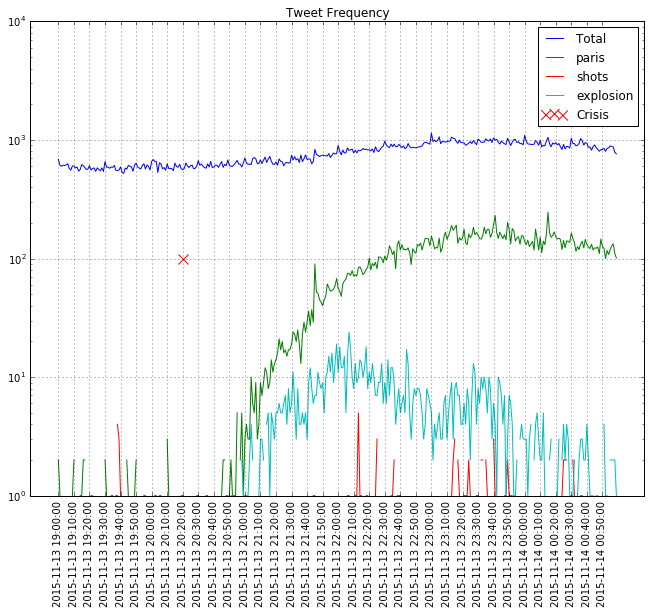

In [55]:
# What keywords are we interested in?
targetKeywords = crisisInfo[selectedCrisis]["keywords"]

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

ax.semilogy(range(len(frequencyMap)), totalCount, label="Total")

ax.scatter([crisisXCoord], [100], c="r", marker="x", s=100, label="Crisis")

for keyword in targetKeywords:
    ax.semilogy(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

<hr>
<img src="files/intermission.jpg">

## Time for a break!

<hr>
# Topic 5: Geographic Data

Data in social media can be relevant to an event in three ways: __temporally__ relevant, __geographically__ relevant, or __topically__ relevant.
So far, we've looked at temporally relevant data, or data that was posted at about the same time as the target event.
Now we'll explore geographically relevant data, or data posted near the event.

Twitter allows users to share their GPS locations when tweeting, but only about 2% of tweets have this information. 
We can extract this geospatial data to look at patterns in different locations. 

- General plotting
- Filtering by a bounding box
- Images from target location

### Plotting GPS Data

Each tweet has a field called "coordinates" describing from where the tweet was posted. 
The field might be null if the tweet contains no location data, or it could contain bounding box information, place information, or GPS coordinates in the form of (longitude, latitude). 
We want tweets with this GPS data.

For more information on tweet JSON formats, check out https://dev.twitter.com/overview/api/tweets

In [56]:
# A frequency map for timestamps to geo-coded tweets
geoFrequencyMap = {}
geoCount = 0

# Save only those tweets with tweet['coordinate']['coordinate'] entity
for t in sortedTimes:
    geos = list(filter(lambda tweet: tweet["coordinates"] != None and 
                       "coordinates" in tweet["coordinates"], 
                       frequencyMap[t]["list"]))
    geoCount += len(geos)
    
    # Add to the timestamp map
    geoFrequencyMap[t] = {"count": len(geos), "list": geos}

print "Number of Geo Tweets:", geoCount

Number of Geo Tweets: 953


#### GPS Frequency

What is the frequency of GPS-coded tweets?

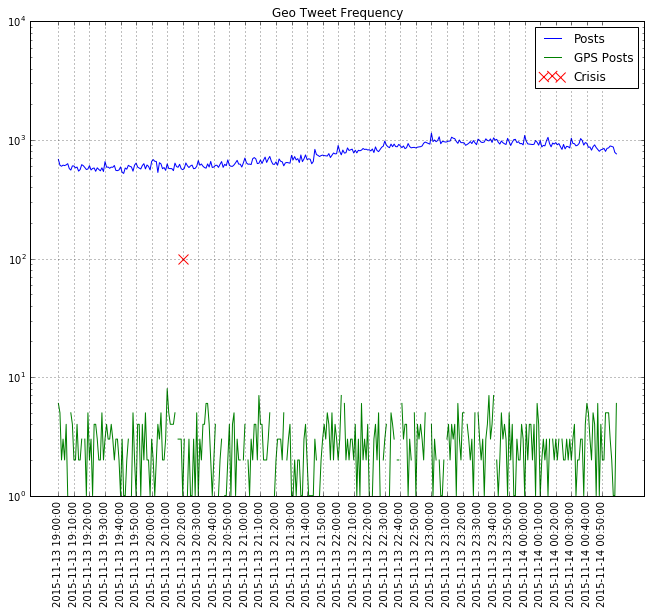

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Geo Tweet Frequency")

gpsFreqList = [geoFrequencyMap[x]["count"] for x in sortedTimes]
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]

plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

xData = range(len(geoFrequencyMap))
gpsYData = [x if x > 0 else 0 for x in gpsFreqList]
freqYData = [x if x > 0 else 0 for x in postFreqList]

ax.semilogy(xData, freqYData, color="blue", label="Posts")
ax.semilogy(xData, gpsYData, color="green", label="GPS Posts")
ax.scatter([crisisXCoord], [100], c="r", marker="x", s=100, label="Crisis")

ax.grid(b=True, which=u'major')
ax.legend()

plt.show()

### Plotting GPS Data

Now that we have a list of all the tweets with GPS coordinates, we can plot from where in the world these tweets were posted. 
To make this plot, we can leverage the Basemap package to make a map of the world and convert GPS coordinates to *(x, y)* coordinates we can then plot.

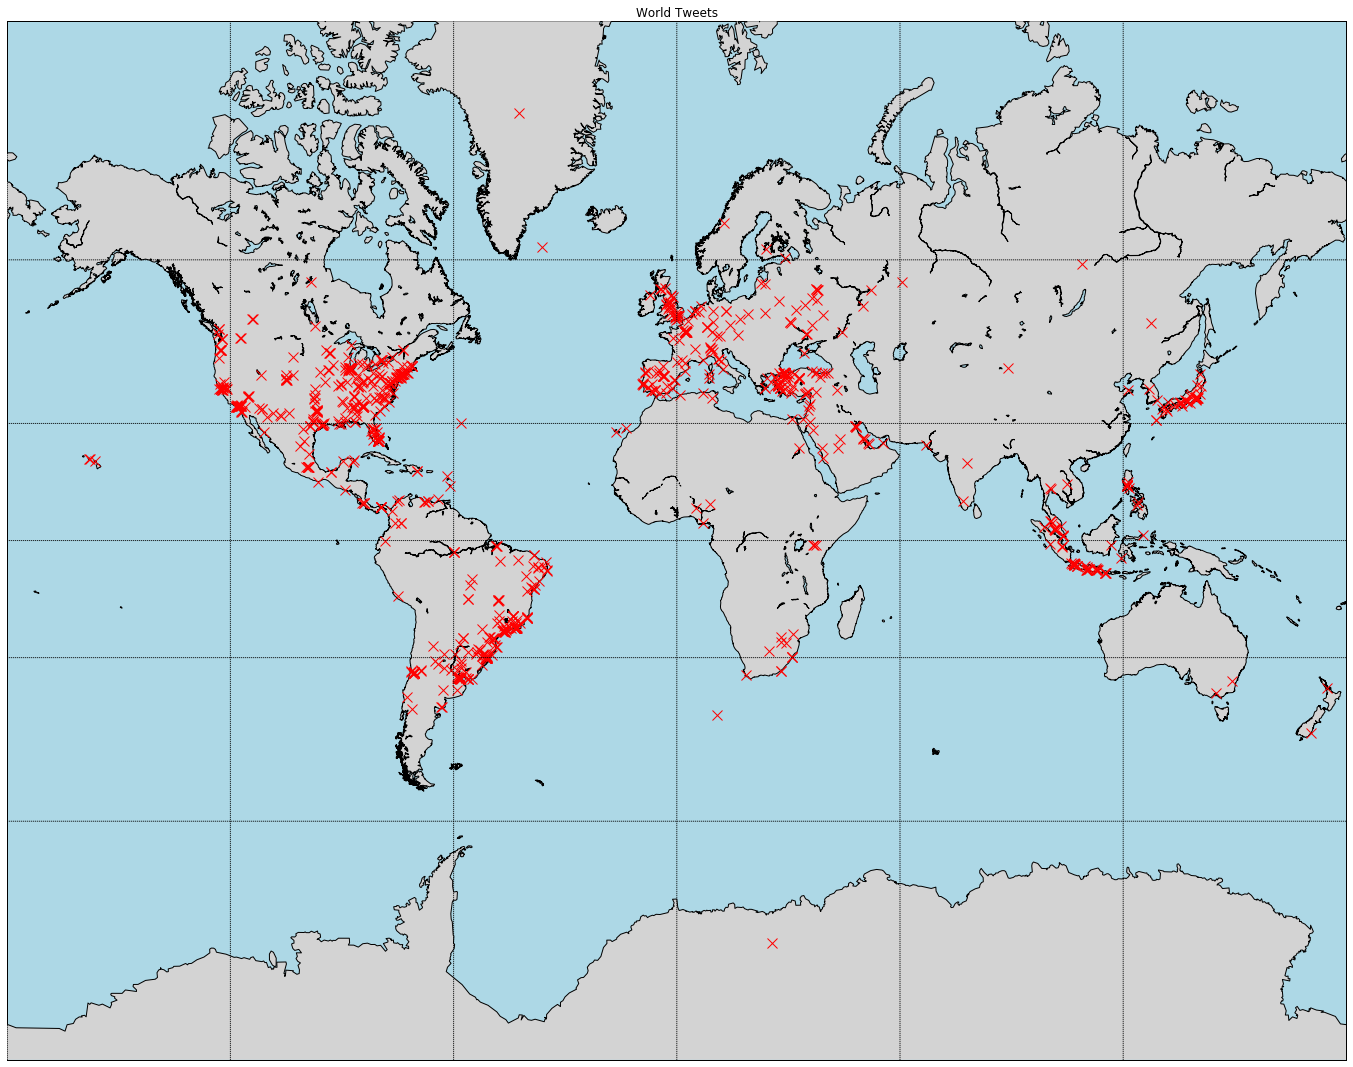

In [58]:
import matplotlib

from mpl_toolkits.basemap import Basemap

# Create a list of all geo-coded tweets
tmpGeoList = [geoFrequencyMap[t]["list"] for t in sortedTimes]
geoTweets = reduce(lambda x, y: x + y, tmpGeoList)

# For each geo-coded tweet, extract its GPS coordinates
geoCoord = [x["coordinates"]["coordinates"] for x in geoTweets]

# Now we build a map of the world using Basemap
land_color = 'lightgray'
water_color = 'lightblue'

fig, ax = plt.subplots(figsize=(24,24))
worldMap = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80,
                   llcrnrlon=-180, urcrnrlon=180, resolution='l')

worldMap.fillcontinents(color=land_color, lake_color=water_color, zorder=1)
worldMap.drawcoastlines()
worldMap.drawparallels(np.arange(-90.,120.,30.))
worldMap.drawmeridians(np.arange(0.,420.,60.))
worldMap.drawmapboundary(fill_color=water_color, zorder=0)
ax.set_title('World Tweets')

# Convert points from GPS coordinates to (x,y) coordinates
convPoints = [worldMap(p[0], p[1]) for p in geoCoord]
x = [p[0] for p in convPoints]
y = [p[1] for p in convPoints]
worldMap.scatter(x, y, s=100, marker='x', color="red", zorder=2)

plt.show()

### Filtering By Location

We can use existing Geographic Information System (GIS) tools to determine from where a tweet was posted.
For example, we could ask whether a particular tweet was posted from the United States. 
This filtering is often performed using shape files.
For our purposes though, we established a bounding box along with the crisis data, so we'll use that as our filter for simplicity.

Tweets in Target Area: 40
Tweets outside: 913


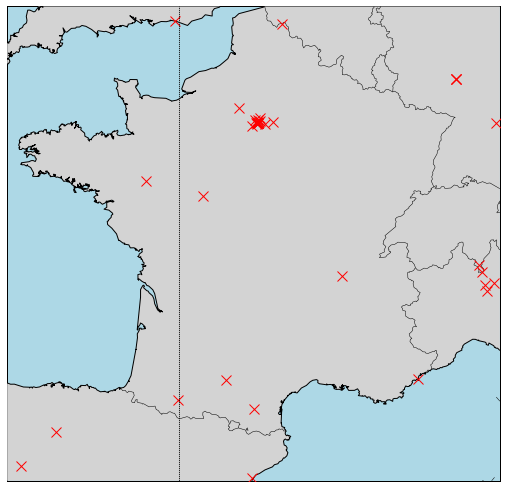

In [59]:
# Get the bounding box for our crisis
bBox = crisisInfo[selectedCrisis]["box"]

fig, ax = plt.subplots(figsize=(11,8.5))

# Create a new map to hold the shape file data
targetMap = Basemap(llcrnrlon=bBox["lowerLeftLon"], 
                    llcrnrlat=bBox["lowerLeftLat"], 
                    urcrnrlon=bBox["upperRightLon"], 
                    urcrnrlat=bBox["upperRightLat"], 
                    projection='merc',
                    resolution='i', area_thresh=10000)

targetMap.fillcontinents(color=land_color, lake_color=water_color, 
                         zorder=1)
targetMap.drawcoastlines()
targetMap.drawparallels(np.arange(-90.,120.,30.))
targetMap.drawmeridians(np.arange(0.,420.,60.))
targetMap.drawmapboundary(fill_color=water_color, zorder=0)
targetMap.drawcountries()

# Now we build the polygon for filtering
# Convert from lon, lat of lower-left to x,y coordinates
llcCoord = targetMap(bBox["lowerLeftLon"], bBox["lowerLeftLat"])

# Same for upper-right corner
urcCoord = targetMap(bBox["upperRightLon"], bBox["upperRightLat"])

# Now make the polygon we'll us for filtering
boxPoints = np.array([[llcCoord[0], llcCoord[1]], 
                      [llcCoord[0], urcCoord[1]], 
                      [urcCoord[0], urcCoord[1]], 
                      [urcCoord[0], llcCoord[1]]])
boundingBox = matplotlib.patches.Polygon(boxPoints)

# Maps of timestamps to tweets for inside/outside Ferguson
inTargetFreqMap = {}
plottablePointsX = []
plottablePointsY = []

# For each geo-coded tweet, extract coordinates and convert 
# them to the Basemap space
for t in sortedTimes:
    geos = geoFrequencyMap[t]["list"]
    convPoints = [(targetMap(tw["coordinates"]["coordinates"][0], tw["coordinates"]["coordinates"][1]), tw) for tw in geos]

    # Local counters for this time
    inTargetFreqMap[t] = {"count": 0, "list": []}
    
    # For each point, check if it is within the bounding box or not
    for point in convPoints:
        x = point[0][0]
        y = point[0][1]

        if ( boundingBox.contains_point((x, y))):
            inTargetFreqMap[t]["list"].append(point[1])
            plottablePointsX.append(x)
            plottablePointsY.append(y)

# Plot points in our target
targetMap.scatter(plottablePointsX, plottablePointsY, s=100, marker='x', color="red", zorder=2)
            
# Count the number of tweets that fall in the area
targetTweetCount = np.sum([len(inTargetFreqMap[t]["list"]) for t in sortedTimes])
            
print "Tweets in Target Area:", targetTweetCount
print "Tweets outside:", (geoCount - targetTweetCount)

plt.show()

### Geographically Relevant Tweet Content

Now that we have a list of tweets from the target area, what are they saying?

In [60]:
# Merge our list of relevant tweets
geoRelevantTweets = [tw for x in sortedTimes for tw in inTargetFreqMap[x]["list"]]

print "Time of Crisis:", crisisTime

# Print the first few tweets
for tweet in geoRelevantTweets[:10]:
    print "Tweet By:", tweet["user"]["screen_name"]
    print "\t", "Tweet Text:", tweet["text"]
    print "\t", "Tweet Time:", tweet["created_at"]
    print "\t", "Source:", tweet["source"]
    print "\t", "Retweets:", tweet["retweet_count"]
    print "\t", "Favorited:", tweet["favorite_count"]
    print "\t", "Twitter's Guessed Language:", tweet["lang"]
    if ( "place" in tweet ):
        print "\t", "Tweet Location:", tweet["place"]["full_name"]
    print "-----"

Time of Crisis: 2015-11-13 20:20:00
Tweet By: Bdsopon
	Tweet Text: @JasikaParvin 😃😃 থাক শুনবো না....
	Tweet Time: Fri Nov 13 19:13:02 +0000 2015
	Source: <a href="http://www.twitter.com" rel="nofollow">Twitter for Windows Phone</a>
	Retweets: 0
	Favorited: 0
	Twitter's Guessed Language: bn
	Tweet Location: Pantin, Ile-de-France
-----
Tweet By: desirecf13
	Tweet Text: Paradise 😍❤️ #switzerland #lugano @ Lugano Paradiso https://t.co/vVWKwBgFlD
	Tweet Time: Fri Nov 13 19:30:18 +0000 2015
	Source: <a href="http://instagram.com" rel="nofollow">Instagram</a>
	Retweets: 0
	Favorited: 0
	Twitter's Guessed Language: es
	Tweet Location: Paradiso, Ticino
-----
Tweet By: macarenamaga
	Tweet Text: I'm at @Paris in Paris, Île-de-France, France, Île-de-France https://t.co/KAh4Ht0wUP
	Tweet Time: Fri Nov 13 19:30:43 +0000 2015
	Source: <a href="http://foursquare.com" rel="nofollow">Foursquare</a>
	Retweets: 0
	Favorited: 0
	Twitter's Guessed Language: fr
	Tweet Location: París, Isla de Francia
-----
T

### Media from Within Target

With this filtered list of tweets, we can extract media posted from the evnet.

In [61]:
from IPython.display import display
from IPython.display import Image

geoTweetsWithMedia = list(filter(lambda tweet: "media" in tweet["entities"], geoRelevantTweets))
print "Tweets with Media:", len(geoTweetsWithMedia)

if ( len(geoTweetsWithMedia) == 0 ):
    print "Sorry, not tweets with media..."

for tweet in geoTweetsWithMedia:
    imgUrl = tweet["entities"]["media"][0]["media_url"]
    print tweet["text"]
    display(Image(url=imgUrl))

Tweets with Media: 0
Sorry, not tweets with media...


---
# Topic 6: Content and Sentiment Analysis

Another popular type of analysis people do on social networks is "sentiment analysis," which is used to figure out how people **feel** about a specific topic.
Some tools also provide measurements like subjectivity/objectivity of text content.

We'll cover:

- Topically Relevant Filtering
- Sentiment, Subjectivity, and Objectivity

### Topically Relevant Tweets

Before we filter for sentiment and such, we've seen that Twitter has a lot of noise and irrelevant data.
We should clean this data a bit before this analysis.
To do so, we'll filter our data so that it only contains tweets with relevant keywords.

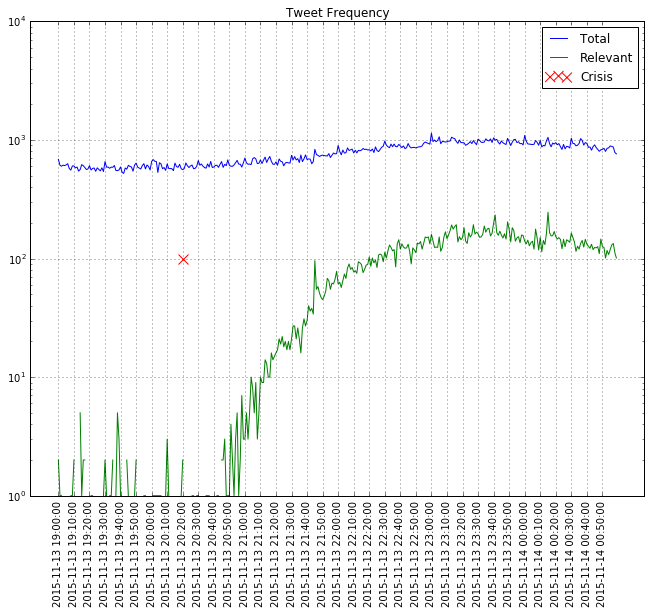

In [62]:
# What keywords are we interested in?
targetKeywords = crisisInfo[selectedCrisis]["keywords"]

# Map for storing topically relevant data
topicRelevantMap = {}

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    topicRelevantMap[t] = {"count": 0, "list": []}
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword.lower() in tweetString ):
                topicRelevantMap[t]["list"].append(tweetObj)
                topicRelevantMap[t]["count"] += 1
                
                break

        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

ax.semilogy(range(len(frequencyMap)), totalCount, label="Total")

ax.scatter([crisisXCoord], [100], c="r", marker="x", s=100, label="Crisis")

relYData = [topicRelevantMap[t]["count"] for t in sortedTimes]
ax.semilogy(range(len(relYData)), relYData, label="Relevant")

ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

### Quick Geo-data Comparison

An interesting comparison might be to look at the areas of concentration of relevant tweets.

Number of Relevant Geo Tweets: 22


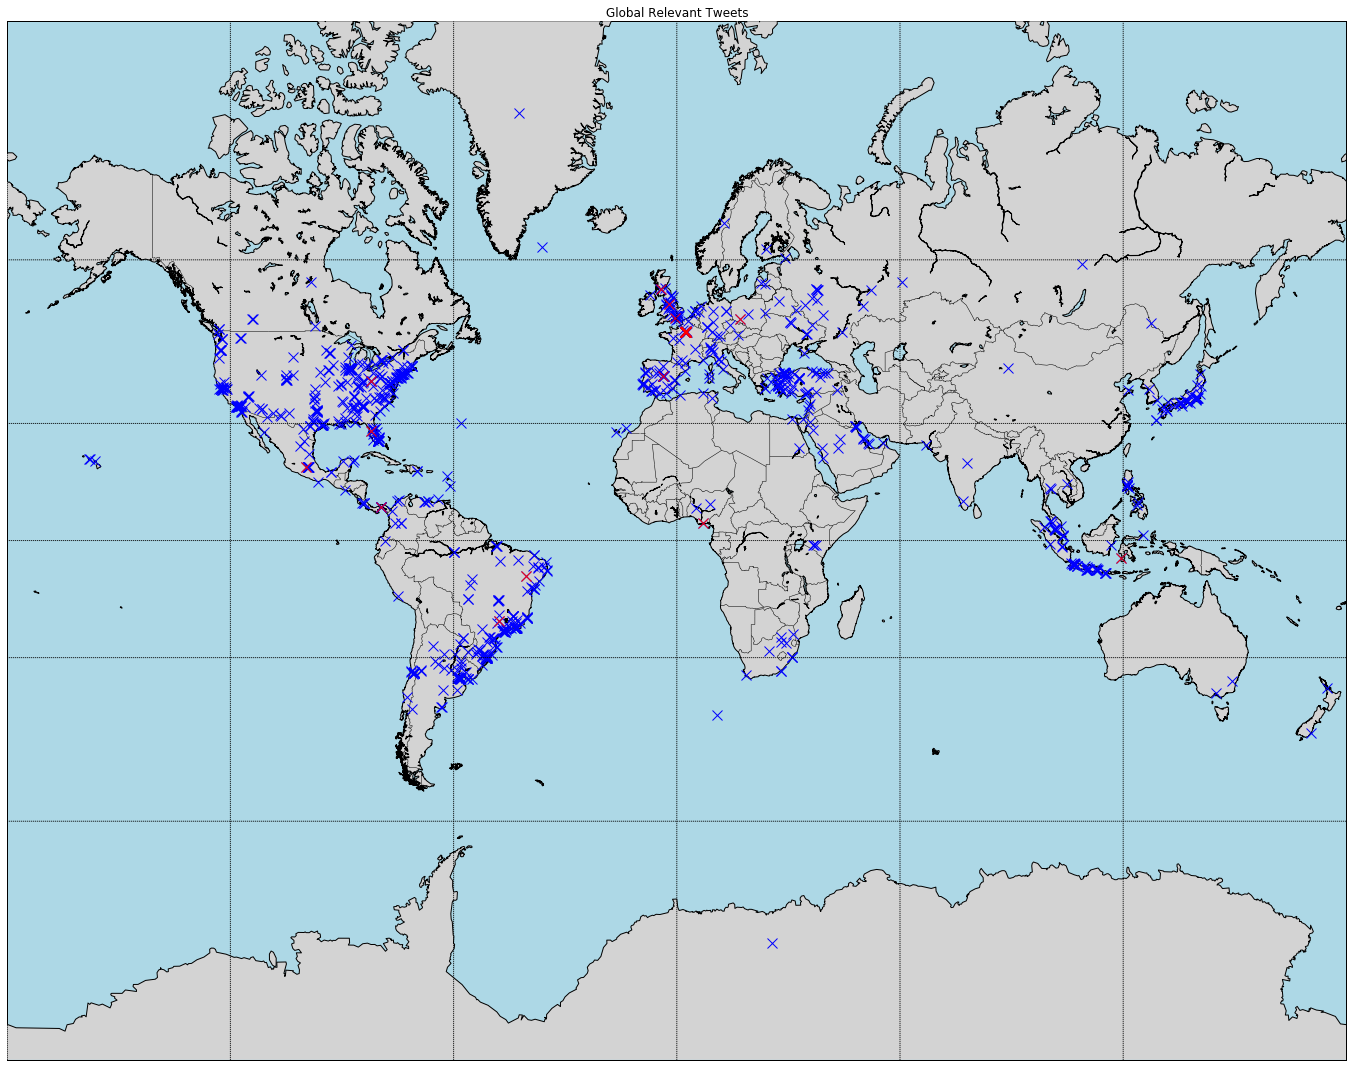

In [63]:
# A frequency map for timestamps to geo-coded tweets
relGeoFreqMap = {}
relGeoCount = 0

# Save only those tweets with tweet['coordinate']['coordinate'] entity
for t in sortedTimes:
    geos = list(filter(lambda tweet: tweet["coordinates"] != None and 
                       "coordinates" in tweet["coordinates"], 
                       topicRelevantMap[t]["list"]))
    relGeoCount += len(geos)
    
    # Add to the timestamp map
    relGeoFreqMap[t] = {"count": len(geos), "list": geos}

print "Number of Relevant Geo Tweets:", relGeoCount

# Create a list of all geo-coded tweets
tmpGeoList = [relGeoFreqMap[t]["list"] for t in sortedTimes]
relGeoTweets = reduce(lambda x, y: x + y, tmpGeoList)

# For each geo-coded tweet, extract its GPS coordinates
relGeoCoord = [x["coordinates"]["coordinates"] for x in relGeoTweets]

fig, ax = plt.subplots(figsize=(24,24))
worldMap = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80,
                   llcrnrlon=-180, urcrnrlon=180, resolution='l')

worldMap.fillcontinents(color=land_color, lake_color=water_color, zorder=1)
worldMap.drawcoastlines()
worldMap.drawparallels(np.arange(-90.,120.,30.))
worldMap.drawmeridians(np.arange(0.,420.,60.))
worldMap.drawmapboundary(fill_color=water_color, zorder=0)
worldMap.drawcountries()
ax.set_title('Global Relevant Tweets')

# Convert points from GPS coordinates to (x,y) coordinates
allConvPoints = [worldMap(p[0], p[1]) for p in geoCoord]
x = [p[0] for p in allConvPoints]
y = [p[1] for p in allConvPoints]
worldMap.scatter(x, y, s=100, marker='x', color="blue", zorder=2)

# Convert points from GPS coordinates to (x,y) coordinates
relConvPoints = [worldMap(p[0], p[1]) for p in relGeoCoord]
x = [p[0] for p in relConvPoints]
y = [p[1] for p in relConvPoints]
worldMap.scatter(x, y, s=100, marker='x', color="red", zorder=2)

plt.show()

__Observation:__ Most topically relevant tweets are not geotagged.

### Sentiment Analysis w/ TextBlob

TextBlob is a nice Python package that provides a number of useful text processing capabilities.
We will use it for sentiment analysis to calculate polarity and subjectivity for each relevant tweet.

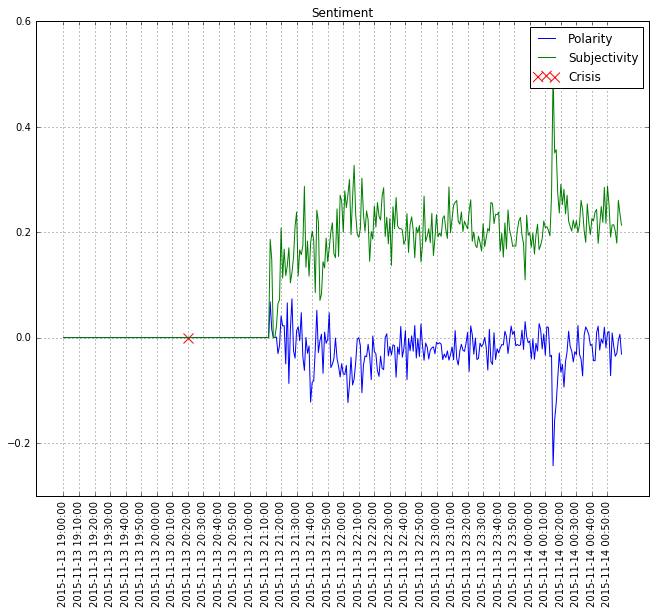

In [64]:
from textblob import TextBlob

# Sentiment values
polarVals = []
objVals = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = topicRelevantMap[t]
    
    # For calculating averages
    localPolarVals = []
    localObjVals = []
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        blob = TextBlob(tweetString)
        polarity = blob.sentiment.polarity
        objectivity = blob.sentiment.subjectivity
        
        localPolarVals.append(polarity)
        localObjVals.append(objectivity)
        
    # Add data to the polarity and objectivity measure arrays
    if ( len(timeObj["list"]) > 10 ):
        polarVals.append(np.mean(localPolarVals))
        objVals.append(np.mean(localObjVals))
    else:
        polarVals.append(0.0)
        objVals.append(0.0)

        
# Now plot this sentiment data
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Sentiment")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

xData = range(len(sortedTimes))

ax.scatter([crisisXCoord], [0], c="r", marker="x", s=100, label="Crisis")

# Polarity is scaled [-1, 1], for negative and positive polarity
ax.plot(xData, polarVals, label="Polarity")

# Subjetivity is scaled [0, 1], with 0 = objective, 1 = subjective
ax.plot(xData, objVals, label="Subjectivity")

ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

---
# Topic 7: Topic Modeling

Along with sentiment analysis, a question often asked of social networks is "What are people talking about?" 
We can answer this question using tools from topic modeling and natural language processing.
With crises, people can have many responses, from sharing specific data about the event, sharing condolonces, or opening their homes to those in need.

To generate these topic models, we will use the Gensim package's implementation of Latent Dirichlet Allocation (LDA), which basically constructs a set of topics where each topic is described as a probability distribution over the words in our tweets. 
Several other methods for topic modeling exist as well.

In [65]:
# Gotta pull in a bunch of packages for this
import gensim.models.ldamulticore
import gensim.matutils
import sklearn.cluster
import sklearn.feature_extraction 
import sklearn.feature_extraction.text
import sklearn.metrics
import sklearn.preprocessing

import nltk

In [ ]:
nltk.download("stopwords")
from nltk.corpus import stopwords

We first extract all relevant tweets' text for building our models.

In [66]:
# Get all tweets and conver to lowercase
allTweetText = [x["text"].lower() for t in sortedTimes for x in topicRelevantMap[t]["list"]]

print "All Tweet Count:", len(allTweetText)

All Tweet Count: 25893


Now we build a list of stop words (words we don't care about) and build a feature generator (the vectorizer) that assigns integer keys to tokens and counts the number of each token.

In [67]:
enStop = stopwords.words('english')
esStop = stopwords.words('spanish')

# Skip stop words, retweet signs, @ symbols, and URL headers
stopList = enStop + esStop + ["http", "https", "rt", "@", ":", "co"]

vectorizer = sklearn.feature_extraction.text.CountVectorizer(strip_accents='unicode', 
                                                             tokenizer=None,
                                                             token_pattern='(?u)#?\\b\\w+[\'-]?\\w+\\b',
                                                             stop_words=stopList)

# Analyzer
analyze = vectorizer.build_analyzer() 

# Create a vectorizer for all our content
vectorizer.fit(allTweetText)

# Get all the words in our text
names = vectorizer.get_feature_names()

# Create a map for vectorizer IDs to words
id2WordDict = dict(zip(range(len(vectorizer.get_feature_names())), names))

We then use the vectorizer to transform our tweet text into a feature set, which essentially is a table with rows of tweets, columns for each keyword, and each cell is the number of times that keyword appears in that tweet.

We then convert that table into a model the Gensim package can handle, apply LDA, and grab the top 10 topics, 10 words that describe that topic, and print them.

In [68]:
# Create a corpus for 
corpus = vectorizer.transform(allTweetText)
gsCorpus = gensim.matutils.Sparse2Corpus(corpus, documents_columns=False)
        
lda = gensim.models.LdaMulticore(gsCorpus, 
                                 id2word=id2WordDict,
                                 num_topics=20, 
                                 passes=2) # ++ passes for better results

ldaTopics = lda.show_topics(num_topics=10, 
                            num_words=10, 
                            formatted=False)

for (i, tokenList) in ldaTopics:
    print "Topic %d:" % i, ' '.join([pair[0] for pair in tokenList])

Topic 0: paris everyone japan heart et attack #paris day des scary
Topic 11: paris attacks #prayforparis hostages prayers police right going killed #paris
Topic 3: paris #paris attacks #prayforparis 100 muertos dead killed france people
Topic 9: paris #prayforparis heart goes #paris et ce luke5sos attacks des
Topic 14: paris #paris #prayforparis vous world des je praying attacked #porteouverte
Topic 6: paris #paris #prayforparis attacks eiffel embassy terror killed france go
Topic 7: paris people prayers thoughts attacks pray dead concert safe 100
Topic 16: paris #prayforparis france #paris attack attacks humanity stade morts people
Topic 18: paris #prayforparis des everyone thinking embassy right france people #parisattacks
Topic 2: paris everyone #paris thinking #prayforparis harry_styles prayers thoughts praying dans


We can also be a little more strict and get rid of some noise by looking only at words with more than X characters.
Stop words are often short, so by putting a floor on the length of a token, we can theoretically get higher-signal data.

In [69]:
import nltk

docArrays = filter(lambda x: len(x) > 4, [y for x in allTweetText for y in analyze(x)])
fd = nltk.FreqDist(docArrays)

print "Most common from analyzer:"
for x in fd.most_common(20):
    print x[0], x[1]

Most common from analyzer:
paris 14182
#prayforparis 5511
#paris 4345
people 2098
prayers 1748
attacks 1689
thoughts 1543
france 1458
everyone 1380
police 958
#parisattacks 953
right 869
please 841
#porteouverte 822
tonight 791
praying 743
attack 738
#fusillade 724
french 722
killed 675


---
# Topic 8: Network Analysis

Information flows and social networks are important considerations during crises, when people are trying to get updates on safe spaces, loved ones, places of shelter, etc.
Twitter is noisy though, and a lot of the data may be irrelevant, condolences/thoughts expressed by celebrities, or otherwise uninformative.
Using network analysis, we can get some idea about who the most important Twitter users were during this time, and how people split into groups online.

For this analysis, we'll use the NetworkX package to construct a social graph of how people interact. Each person in our Twitter data will be a node in our graph, and edges in the graph will represent mentions during this timeframe.
Then we will explore a few simple analytical methods in network analysis, including:

- Central accounts
- Visualization

### Graph Building

To limit the amount of data we're looking at, we'll only build the network for people who tweeted about a relevant keyword and the people they mention. 
We build this network simply by iterating through all the tweets in our relevant list and extract the "user_mentions" list from the "entities" section of the tweet object.
For each mention a user makes, we will add an edge from that user to the user he/she mentioned.

In [70]:
import networkx as nx

# We'll use a directed graph since mentions/retweets are directional
graph = nx.DiGraph()
    
for tweet in [x for t in sortedTimes for x in topicRelevantMap[t]["list"]]:
    userName = tweet["user"]["screen_name"]
    graph.add_node(userName)

    mentionList = tweet["entities"]["user_mentions"]

    for otherUser in mentionList:
        otherUserName = otherUser["screen_name"]
        if ( graph.has_node(otherUserName) == False ):
            graph.add_node(otherUserName)
        graph.add_edge(userName, otherUserName)
        
print "Number of Users:", len(graph.node)

Number of Users: 34489


### Central Users

In network analysis, "centrality" is used to measure the importance of a given node. 
Many different types of centrality are used to describe various types of importance though.
Examples include "closeness centrality," which measures how close a node is to all other nodes in the network, versus "betweeness centrality," which measures how many shortest paths run through the given node.
Nodes with high closeness centrality are important for rapidly disseminating information or spreading disease, whereas nodes with high betweeness are more important to ensure the network stays connected.

The PageRank is another algorithm for measuring importance and was proposed by Sergey Brin and Larry Page for the early version of Google's search algorithm.
NetworkX has an implementation of the PageRank algorithm that we can use to look at the most important/authoritative users on Twitter based on their connections to other users.

In [71]:
# Now we prune for performance reasons
# remove all nodes with few edges

graph.remove_nodes_from((n for n,d in graph.degree_iter() if d<2))
print "Number of Remaining Users:", len(graph.node)

Number of Remaining Users: 2840


In [72]:
# THis may take a while
pageRankList = nx.pagerank_numpy(graph)

In [73]:
highRankNodes = sorted(pageRankList.keys(), key=pageRankList.get, reverse=True)
for x in highRankNodes[:20]:
    print x, pageRankList[x]
    

AP 0.00935991872782
POTUS 0.00738666443282
AFP 0.00571144214245
Conflicts 0.00554050109241
fhollande 0.00514391785632
BFMTV 0.0048666753254
Paris 0.00448066658217
prefpolice 0.00430972553214
FoxNews 0.00419006679711
WhiteHouse 0.0041387844821
BuzzFeedNews 0.00407040806208
CNN 0.00366014954199
SkyNews 0.00361406978068
BarackObama 0.00297638534184
infos140 0.00288749599582
itele 0.0028122819338
LesNews 0.00268578555677
RT_com 0.00260031503176
FRANCE24 0.00256612682175
Reuters 0.00222424472167


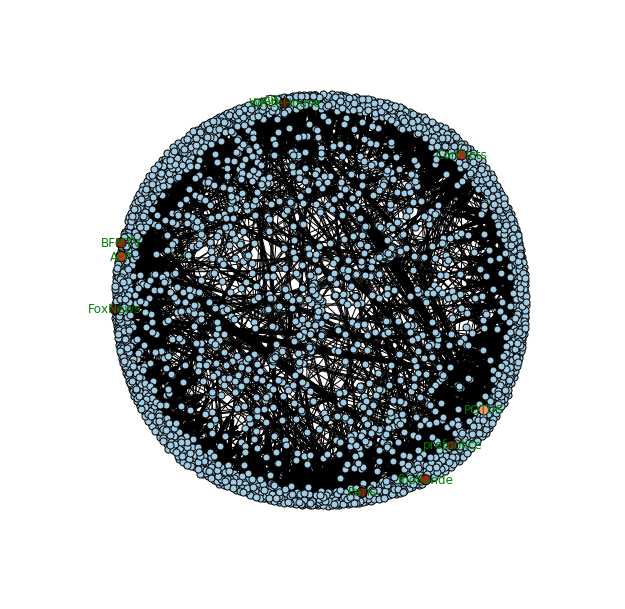

In [74]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(graph, scale=100, iterations=100, k=0.2)
nx.draw(graph, 
        pos, 
        node_color='#A0CBE2', 
        width=1, 
        with_labels=False,
        node_size=50)

hrNames = highRankNodes[:10]
hrDict = dict(zip(hrNames, hrNames))
hrValues = [pageRankList[x] for x in hrNames]

nx.draw_networkx_nodes(graph,pos,nodelist=hrNames,
                       node_size=100,
                       node_color=hrValues,
                       cmap=plt.cm.Reds_r)

nx.draw_networkx_labels(graph,
                        pos,
                        labels=hrDict,
                        fontsize=36,
                        font_color="g")

plt.axis('off')
plt.show()